In [1]:
import pandas as pd
import pickle
import sys
sys.path.append('..')
import numpy as np
import os

In [2]:
folder = "result/250-250_0.7_0.8/"

In [3]:
### read result from ST with scaling sigmasq
num_data = 100
d = 200
truncate = 1
sigmasq = 0.5
rho_0 = 10
Niter = 3100
step = 0.1
error_ST = np.zeros(shape = (6, num_data, Niter))
time_ST = np.zeros(shape = (num_data, Niter))
iter_max = np.zeros(shape = (num_data), dtype = np.int32)
for ii in range(0,num_data):
    with open(folder + 'NormInitm1_ST_%.1f_%.1f_%.1f_%f/error-time%i.pkl' %(truncate, sigmasq, rho_0, step, ii), 'rb') as f:  # Python 3: open(..., 'wb')
        error, Res_theta, Res_delta= pickle.load(f)
        iter_max[ii] = len(error)
        error_ST[0:2, ii, :iter_max[ii]] = error[:, 2:4].T
        error_ST[2:6, ii, :iter_max[ii]] = error[:, 5:9].T
        time_ST[ii, :iter_max[ii]] = error[:, 4]
#             list1 = np.delete(np.arange(d//2), [0, 5, 10])
#             list2 = np.delete(np.arange(d//2, d), [0, 5, 10])
#             t1_tnr = 1 - np.sum(Res_delta[I==0][burnin:ll, list1], axis = 1) / (d//2 -3)
#             t2_tnr = 1 - np.sum(Res_delta[I==0][burnin:ll, list2], axis = 1) / (d//2 -3)

In [13]:
### read result from mixedcca
iter_mix =  np.zeros(shape = (2, num_data))
time_mix =  np.zeros(shape = (2, num_data))
for ii in range(0,num_data):
    for k in range(2):
        res = pd.read_csv(folder +'FALSEmixedcca/error-time%i_%i.csv' %(k+1, ii), header=None, sep = ' ').values
        iter_mix[k, ii] = res.shape[1]
        time_mix[k, ii] = res[6,-1]
np.mean(time_mix, axis = 1)

array([10.60975456,  9.78985455])

In [14]:
### read result from mixedcca
error_mixedcca = np.zeros(shape = (2, 6, num_data, Niter)) ## (BICtype, vector pair, number of experiments, iterations)
TPR_mixedcca = np.zeros(shape = (2, 2, num_data, Niter))
time_mixedcca = np.zeros(shape = (2, num_data, Niter))
iter_mixedcca = np.zeros(shape = (2, num_data), dtype = np.int32)
for ii in range(0,num_data):
    for k in range(2):
        res = pd.read_csv(folder +'FALSEmixedcca/error-time%i_%i.csv' %(k+1, ii), header=None, sep = ' ').values
        iter_mix = res.shape[1]
        iter_mixedcca[k, ii] = iter_mix
        error_mixedcca[k, :,ii, 0] = error_ST[:, ii, 0]
        error_mixedcca[k, :,ii, 1:(iter_mix+1)] = res[:6,:]
        error_mixedcca[k, :,ii, (iter_mix+1):] = np.tile(res[:6,-1],(Niter - iter_mix-1, 1 )).T
        time_mixedcca[k, ii, :] = res[6,-1]/iter_mix * np.arange(Niter)
        

In [6]:
### read result from rifle
error_rifle = np.zeros(shape = (6, num_data, Niter)) ## (BICtype, vector pair, number of experiments, iterations)
time_rifle = np.zeros(shape = (num_data, Niter))
for ii in range(0,num_data):
    res = pd.read_csv(folder +'rifle/error-time%i.csv' %(ii), header=None, sep = ' ').values
    iter_rifle = res.shape[1]
    error_rifle[ :,ii, :iter_rifle] = res[:6,:]
    error_rifle[ :,ii, iter_rifle:] = np.tile(res[:6,-1],(Niter - iter_rifle, 1 )).T
#     print(iter_rifle, res[6,-1])
    time_rifle[ ii, :] = res[6,-1]/iter_rifle * np.arange(Niter)

In [27]:
import matplotlib.pyplot as plt
import numpy as np
def plotItr(error_dict,itr_max = 2000, colname = " ",figname = False):
    colors = ['r','b','g','c','k','m','y']
    markers = ['s','o','v','^','+','x','>']
    linestyles = ['-','-','-','-',':',':','-.']
    i = 0
    
    fig = plt.figure()
    for algo, error in error_dict.items():
        c = colors[i]
        mkr = markers[i]
        ls = linestyles[i]
        fmt = ls + c + mkr
        step = 1
        chosen_points = np.arange(0, itr_max, step)
        markers_on = np.arange(0, itr_max//step, itr_max//step//5)
        mkrstyle = {'linewidth': 2, 'markersize': 6, 'markeredgewidth': 2, \
                       'markeredgecolor': c, 'markerfacecolor': c}
        
        plt.plot(chosen_points, error[chosen_points], fmt, markevery=markers_on, **mkrstyle, label = algo)
        i = i + 1
    labelsize = 20
    ticksize = 16
    legendsize = 16
#     plt.ylim(0,2.2)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.xlabel(r'Iteration',fontsize = labelsize)
#     plt.ylabel(colname,fontsize = labelsize)
    plt.gca().legend(fontsize=legendsize)
    plt.tight_layout()
    if figname:
        # print('Fig saved!')
        plt.savefig(figname+'.png',bbox_inches = 0)
    plt.show()

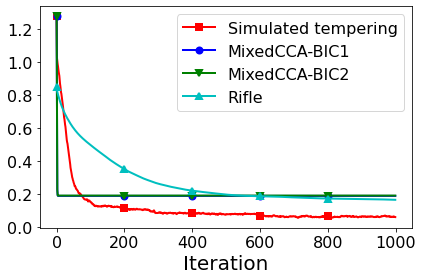

In [29]:
ind = 0
start_itr = 0
itrm = 1000
# itrm = np.min(iter_max[np.nonzero(iter_max)])

error_dict = {'Simulated tempering': np.mean(error_ST[ind, :,start_itr:itrm], axis = 0), 
              'MixedCCA-BIC1': np.mean(error_mixedcca[0,ind, :,start_itr:itrm], axis = 0),
             'MixedCCA-BIC2': np.mean(error_mixedcca[1,ind, :,start_itr:itrm], axis = 0),
             'Rifle': np.mean(error_rifle[ind, :,start_itr:itrm], axis = 0)}
plotItr(error_dict, itrm - start_itr, r'squared $l_2$ error ($v_y$)', figname = 'errorx')

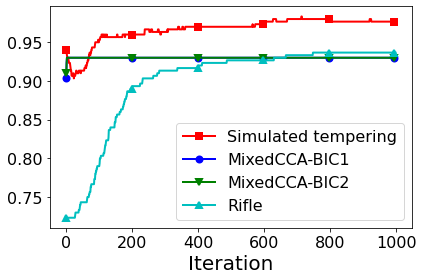

In [34]:
ind = 3
start_itr = 1
itrm = 1000
# itrm = np.min(iter_max[np.nonzero(iter_max)])

error_dict = {'Simulated tempering': np.mean(error_ST[ind, :,start_itr:itrm], axis = 0), 
              'MixedCCA-BIC1': np.mean(error_mixedcca[0,ind, :,start_itr:itrm], axis = 0),
             'MixedCCA-BIC2': np.mean(error_mixedcca[1,ind, :,start_itr:itrm], axis = 0),
             'Rifle': np.mean(error_rifle[ind, :,start_itr:itrm], axis = 0)}
plotItr(error_dict, itrm - start_itr, r'TNR ($v_y$)', figname = 'tpry')

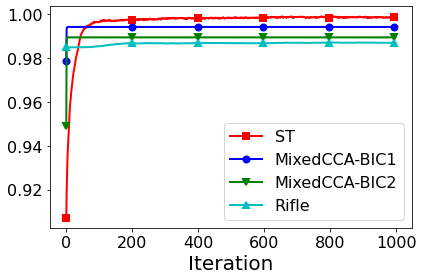

In [36]:
ind = 4
start_itr = 1
itrm = np.min(iter_max[np.nonzero(iter_max)])
itrm = 1000
error_dict = {'ST': np.mean(error_ST[ind, :,start_itr:itrm], axis = 0), 
              'MixedCCA-BIC1': np.mean(error_mixedcca[0,ind, :,start_itr:itrm], axis = 0),
             'MixedCCA-BIC2': np.mean(error_mixedcca[1,ind, :,start_itr:itrm], axis = 0),
             'Rifle': np.mean(error_rifle[ind, :,start_itr:itrm], axis = 0)}
plotItr(error_dict, itrm - start_itr, figname = 'tnrx')